# SM2 — Apartment Overheating (Atrea) — 2024 vs 2025

This notebook analyzes **apartment overheating** using **Atrea** data as a proxy for indoor conditions.

### Context & assumptions
- SM2 has a concrete skeleton (high thermal mass) and a well-insulated facade; heat that enters stays inside.
- Large windows without centralized shading allow solar gains.
- All apartments have heat-recovery ventilation (HRV) with limited air exchange; during heat waves HRV supplies already hot air.
- We use **Atrea `temp_indoor`** (exhaust air from apartments) as a **proxy for indoor apartment temperature**.

### Goals
1. For each **section** (sm2_01..sm2_09), compute **number of days per year** when the **daily maximum** of `temp_indoor` **exceeds 27 °C**.
2. Compare **2024 vs 2025** across sections.
3. Provide both **absolute counts** and **rates** (share of observed days above threshold), plus time series snapshots.

**Time zone:** We compute daily aggregates in **Europe/Prague** local time.


In [1]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, re

plt.rcParams['figure.figsize'] = (12, 6)
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)


## Download & load data
Parquet is preferred; CSV.GZ is a fallback.

In [2]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Check IDs or internet access.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 84.8MB/s]


Shape: (651332, 6)


,time,location,source,measurement,data_key,data_value
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4


## Filter to Atrea `temp_indoor` and derive local day (Europe/Prague)

In [3]:
atrea = df[(df['source']=='Atrea') & (df['data_key']=='temp_indoor')].copy()
atrea['local_time'] = atrea['time'].dt.tz_convert('Europe/Prague')
atrea['local_day'] = atrea['local_time'].dt.floor('D')
atrea['year'] = atrea['local_time'].dt.year
print('Atrea temp_indoor rows:', len(atrea))
atrea.head(3)


Atrea temp_indoor rows: 136224


,time,location,source,measurement,data_key,data_value,local_time,local_day,year
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
7,2023-11-30 13:00:00+00:00,sm2_02,Atrea,nonadditive,temp_indoor,21.0,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
12,2023-11-30 13:00:00+00:00,sm2_03,Atrea,nonadditive,temp_indoor,21.0,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023


## Daily maxima per section and year; days above 27 °C

We compute per `(section, local_day)` the daily **max** of `temp_indoor`, then aggregate to per-year counts and rates.

In [5]:
THRESH = 27.0
daily = (atrea.groupby(['location','local_day'])['data_value']
               .max()
               .reset_index(name='daily_max'))
daily['year'] = daily['local_day'].dt.year

yearly = (daily.groupby(['location','year'])
                .agg(days_observed=('local_day','nunique'),
                     days_over_27=('daily_max', lambda s: int((s>=THRESH).sum())),
                     max_of_max=('daily_max','max'),
                     p95=('daily_max', lambda s: float(np.nanpercentile(s,95))))
                .reset_index())
yearly['rate_over_27_%'] = (100.0 * yearly['days_over_27'] / yearly['days_observed']).round(2)
display(yearly.sort_values(['year','days_over_27'], ascending=[True, False]))
yearly.to_csv(OUT_DIR / 'atrea_over27_by_section_year.csv', index=False)
print('Saved:', OUT_DIR / 'atrea_over27_by_section_year.csv')


,location,year,days_observed,days_over_27,max_of_max,p95,rate_over_27_%
0,sm2_01,2023,32,0,23.3,23.200,0.00
3,sm2_02,2023,32,0,23.5,23.345,0.00
6,sm2_03,2023,32,0,22.9,22.645,0.00
9,sm2_04,2023,32,0,22.1,21.945,0.00
12,sm2_05,2023,32,0,23.5,23.300,0.00
15,sm2_06,2023,32,0,20.3,19.935,0.00
18,sm2_07,2023,32,0,21.3,21.245,0.00
21,sm2_08,2023,32,0,22.6,22.600,0.00
24,sm2_09,2023,32,0,21.7,21.600,0.00
7,sm2_03,2024,366,94,40.8,30.000,25.68


Saved: outputs/atrea_over27_by_section_year.csv


## Bar charts: days above 27 °C — 2024 vs 2025 (grouped by section)

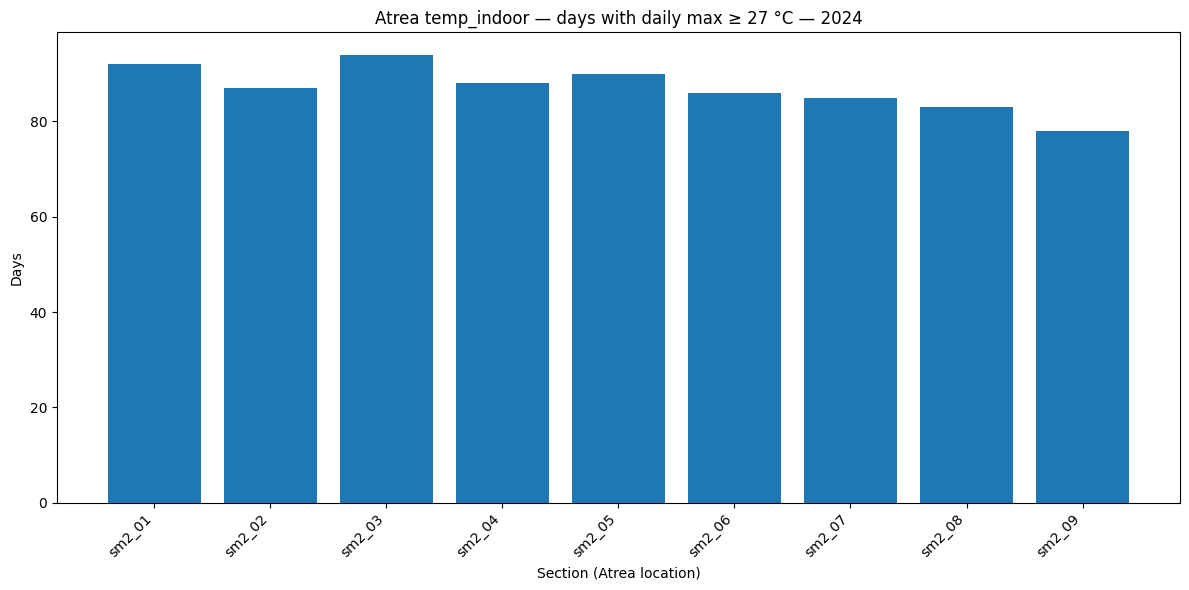

Saved: outputs/atrea_days_over27_2024.png


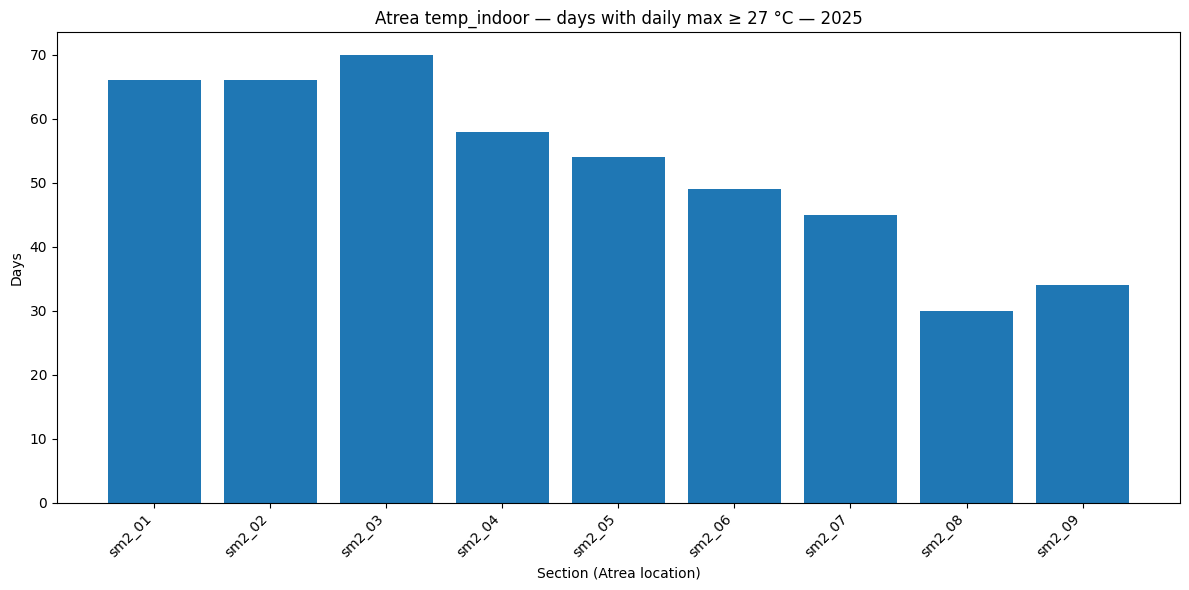

Saved: outputs/atrea_days_over27_2025.png


In [6]:
for y in [2024, 2025]:
    sub = yearly[yearly['year']==y].sort_values('location')
    if sub.empty:
        print(f'No data for {y}');
        continue
    fig = plt.figure()
    ax = plt.gca()
    ax.bar(sub['location'].astype(str), sub['days_over_27'].astype(int))
    ax.set_title(f'Atrea temp_indoor — days with daily max ≥ 27 °C — {y}')
    ax.set_xlabel('Section (Atrea location)')
    ax.set_ylabel('Days')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'atrea_days_over27_{y}.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / f'atrea_days_over27_{y}.png')


## Comparative bar chart: 2024 vs 2025 side-by-side

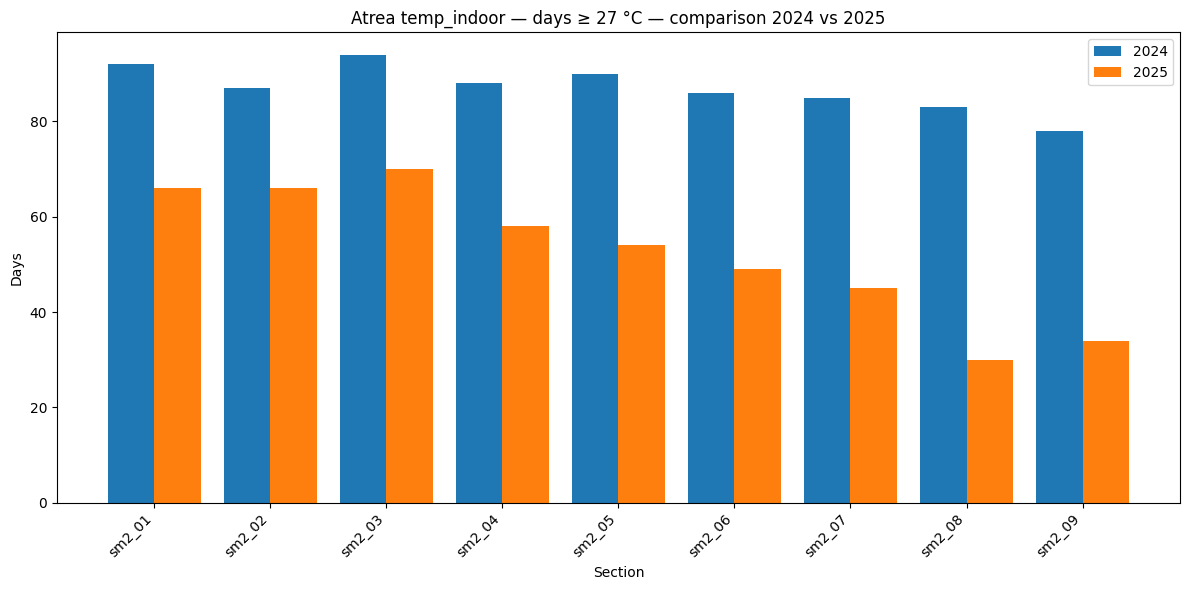

Saved: outputs/atrea_days_over27_2024_vs_2025.png


In [7]:
wide = yearly.pivot(index='location', columns='year', values='days_over_27').fillna(0).sort_index()
fig = plt.figure()
ax = plt.gca()
idx = np.arange(len(wide.index))
width = 0.4
vals_2024 = wide[2024].values if 2024 in wide.columns else np.zeros(len(idx))
vals_2025 = wide[2025].values if 2025 in wide.columns else np.zeros(len(idx))
ax.bar(idx - width/2, vals_2024, width, label='2024')
ax.bar(idx + width/2, vals_2025, width, label='2025')
ax.set_xticks(idx)
ax.set_xticklabels(wide.index.astype(str), rotation=45, ha='right')
ax.set_title('Atrea temp_indoor — days ≥ 27 °C — comparison 2024 vs 2025')
ax.set_xlabel('Section')
ax.set_ylabel('Days')
ax.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / 'atrea_days_over27_2024_vs_2025.png', dpi=150)
plt.show()
print('Saved:', OUT_DIR / 'atrea_days_over27_2024_vs_2025.png')


## Time series snapshot: daily max per section (summer window)

Meteorological summer: **June 1 – Aug 31** (local time). We plot daily maxima per section.

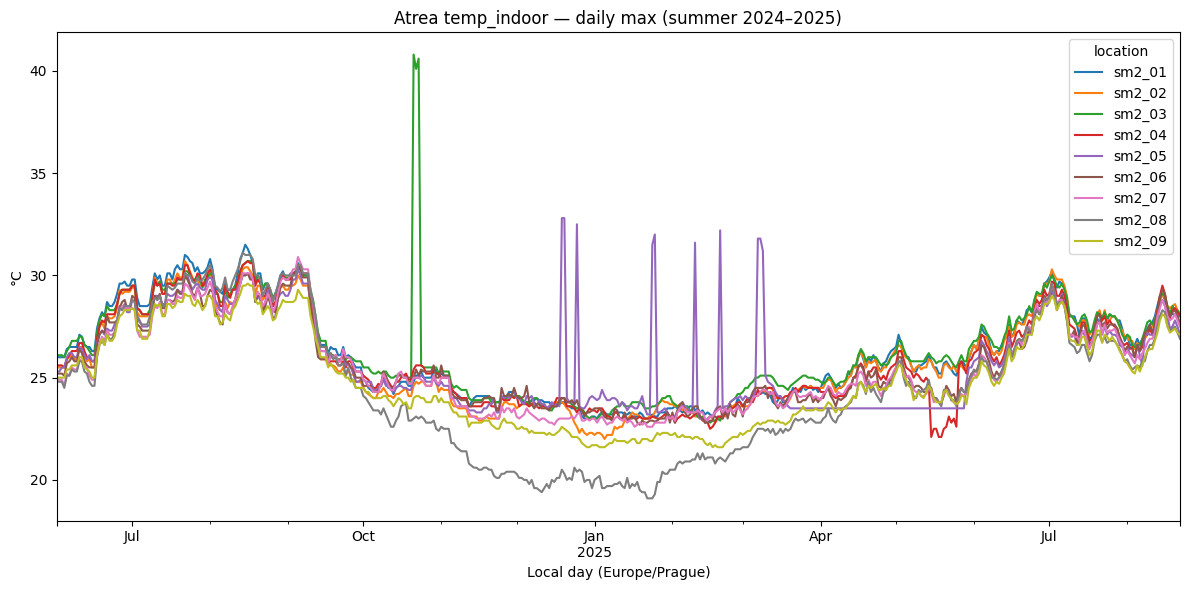

Saved: outputs/atrea_daily_max_summer_2024_2025.png


In [8]:
summer = daily[(daily['local_day']>=pd.Timestamp('2024-06-01', tz='Europe/Prague')) & (daily['local_day']<=pd.Timestamp('2025-08-31', tz='Europe/Prague'))]
if not summer.empty:
    piv = summer.pivot_table(index='local_day', columns='location', values='daily_max')
    fig = plt.figure()
    ax = plt.gca()
    piv.plot(ax=ax, legend=True)
    ax.set_title('Atrea temp_indoor — daily max (summer 2024–2025)')
    ax.set_xlabel('Local day (Europe/Prague)')
    ax.set_ylabel('°C')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'atrea_daily_max_summer_2024_2025.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / 'atrea_daily_max_summer_2024_2025.png')
else:
    print('No summer data to plot.')
